### check correction of pixc height data. 
1. geophysical correction;  
2. height reference correction.  

In [1]:
import numpy as np
import xarray as xr
from glob import glob
import geopandas as gpd
import matplotlib.pyplot as plt
from utils.functions import iter_IQR, pixc_geophy_cor


In [2]:
dir_pixc = 'data/dianchi-lake/pixc'
dir_raster = 'data/dianchi-lake/raster' 
paths_pixc = sorted(glob(dir_pixc + '/*masked.nc'))
paths_raster = sorted(glob(dir_raster + '/*masked.nc'))


In [3]:
# path_pixc = 'data/dianchi-lake/pixc/SWOT_L2_HR_PIXC_014_049_198L_20240419T050213_20240419T050224_PIC0_01_masked.nc'
# path_raster = 'data/dianchi-lake/raster/SWOT_L2_HR_Raster_100m_UTM48R_N_x_x_x_009_049_099F_20240105T211638_20240105T211659_PIC0_01_masked.nc'
id_path = 2
path_pixc, path_raster = paths_pixc[id_path], paths_raster[id_path]
path_lake_vec = 'data/dianchi-lake/dianchi_vector.gpkg'
path_img = 'data/rsimg/dianchi_s2_20200511_wgs84.tif'


In [4]:
pixc_nc = xr.open_dataset(path_pixc)
raster_nc = xr.open_dataset(path_raster)
lake_gpd = gpd.read_file(path_lake_vec)
raster_nc
# pixc_nc

<xarray.Dataset>
Dimensions:    (x: 196, y: 310)
Coordinates:
  * x          (x) float64 102.6 102.6 102.6 102.6 ... 102.8 102.8 102.8 102.8
  * y          (y) float64 24.96 24.96 24.96 24.96 ... 24.67 24.67 24.67 24.67
Data variables:
    crs        int64 ...
    longitude  (y, x) float64 ...
    latitude   (y, x) float64 ...
    wse        (y, x) float32 ...
    sig0       (y, x) float32 ...
    geoid      (y, x) float32 ...
    wse_qual   (y, x) float32 ...
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    source:                        Ka-band radar interferometer
    history:                       2024-03-12T12:53:29Z : Creation
    platform:                      SWOT
    references:                    V1.2.1
    ...                            ...
    x_min:                         196100.0
    x_max:                         346100.0
    y_min:                         2644900.0
    y_max:                         2794800.0
    institution:                   CNES
    product_version:               01

In [5]:
### correction for pixc data
heights_cor = pixc_geophy_cor(pixc_nc=pixc_nc)
heights_cor = heights_cor - pixc_nc.geoid.values   ## to egm2008 height


In [61]:
## outliers removal
pixc_height_IQR, IQR = iter_IQR(arr=pixc_nc.height.values, IQR_thre=0.5, iter_max=4)
pixc_height_cor_IQR, IQR = iter_IQR(arr=heights_cor, IQR_thre=0.5, iter_max=4)
raster_wse_IQR, IQR = iter_IQR(arr=raster_nc.wse.values, IQR_thre=0.5, iter_max=4)



In [62]:
# Calculate the extent of the raster_wgs84_nc using its coordinates
xmin, xmax = raster_nc.x.min().item(), raster_nc.x.max().item()
ymin, ymax = raster_nc.y.min().item(), raster_nc.y.max().item()
raster_extent = [xmin, xmax, ymin, ymax]
raster_extent


[102.59903234246654, 102.78372226038918, 24.66971022259297, 24.962372707916533]

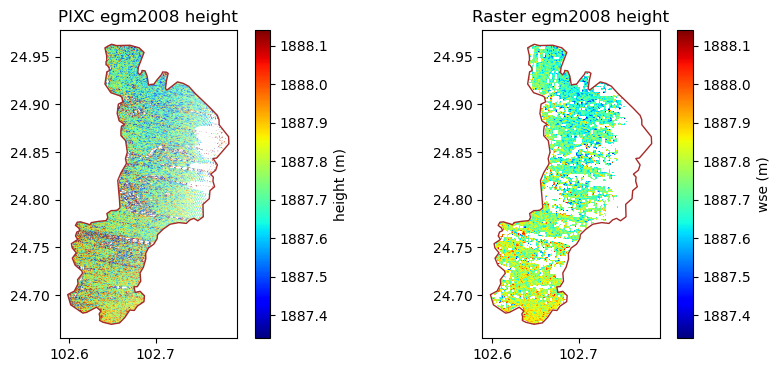

In [63]:
height_min = np.nanmedian(pixc_height_cor_IQR.filled(np.nan))-0.4
height_max = np.nanmedian(pixc_height_cor_IQR.filled(np.nan))+0.4

fig, ax = plt.subplots(1, 2, figsize=(10,4))
# ax1
scat1 = ax[0].scatter(x=pixc_nc.longitude, y=pixc_nc.latitude, c=pixc_height_cor_IQR.filled(np.nan),
           s=0.1, edgecolor='none', cmap='jet', vmin=height_min, vmax=height_max)
lake_gpd.plot(ax=ax[0], edgecolor='Brown', facecolor='none', linewidth=1)
ax[0].set_title('PIXC egm2008 height')
# ax2
im2 = ax[1].imshow(raster_wse_IQR, cmap='jet', extent=raster_extent, vmin=height_min, vmax=height_max)
lake_gpd.plot(ax=ax[1], edgecolor='Brown', facecolor='none', linewidth=1)
ax[1].set_title('Raster egm2008 height')
fig.colorbar(scat1, ax=ax[0]).set_label('height (m)')
fig.colorbar(im2, ax=ax[1]).set_label('wse (m)')


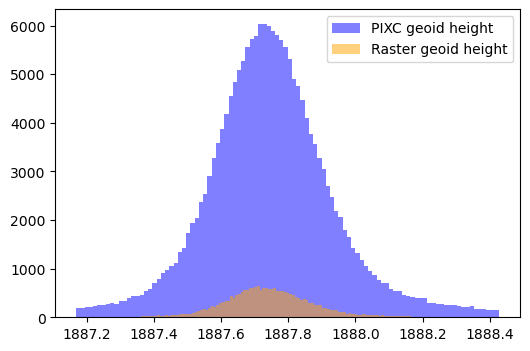

In [64]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(pixc_height_cor_IQR.filled(np.nan), bins=100, label='PIXC geoid height', alpha=0.5, color='blue');
ax.hist(raster_wse_IQR.filled(np.nan).ravel(), bins=100, label='Raster geoid height', alpha=0.5, color='orange');
ax.legend()


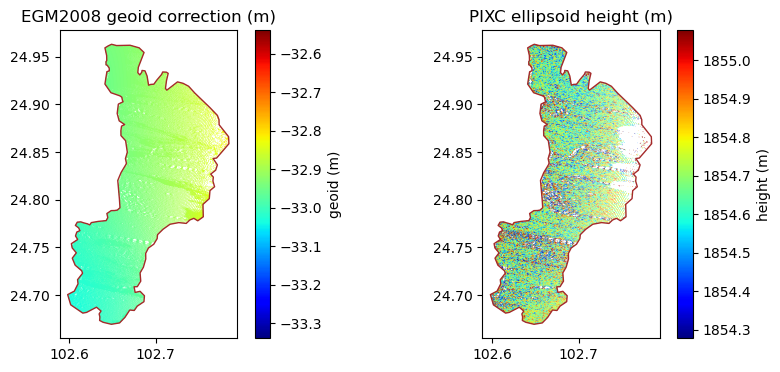

In [71]:
height_min = np.nanmedian(pixc_height_IQR.filled(np.nan))-0.4
height_max = np.nanmedian(pixc_height_IQR.filled(np.nan))+0.4

fig, ax = plt.subplots(1, 2, figsize=(10,4))
## ax1
scat1 = ax[0].scatter(x=pixc_nc.longitude, y=pixc_nc.latitude, c=pixc_nc.geoid,
                                  s=0.1, edgecolor='none', cmap='jet', 
                                  vmin=np.median(pixc_nc.geoid)-0.4, vmax=np.median(pixc_nc.geoid)+0.4)
lake_gpd.plot(ax=ax[0], edgecolor='Brown', facecolor='none', linewidth=1)
ax[0].set_title('EGM2008 geoid correction (m)')
# ax2
scat2 = ax[1].scatter(x=pixc_nc.longitude, y=pixc_nc.latitude, c=pixc_height_IQR.filled(np.nan),
           s=0.1, edgecolor='none', cmap='jet', vmin=height_min, vmax=height_max)
lake_gpd.plot(ax=ax[1], edgecolor='Brown', facecolor='none', linewidth=1)
ax[1].set_title('PIXC ellipsoid height (m)')
fig.colorbar(scat1, ax=ax[0]).set_label('geoid (m)')
fig.colorbar(scat2, ax=ax[1]).set_label('height (m)')
